In the following notes we will model text data. The goal is to be able to predict whether a given text message is spam or not. Afterwards, we will try to predict the category of a news article.

In [197]:
from pprint import pprint

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


from acquire import prep_text
from acquire import get_inshorts_articles
from prepare import basic_clean, lemmatize, remove_stopwords

In [2]:
document = "Smelly Meli with a big pink belly."

# Clean the text.
document = basic_clean(document)

In [3]:
# Transform the sentence into a series.
words = pd.Series(document.split())

In [4]:
words

0    smelly
1      meli
2      with
3         a
4       big
5      pink
6     belly
dtype: object

In [5]:
# Get the raw count for term frequency.
(pd.DataFrame({'raw_count': words.value_counts()})
.assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
.assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
big,1,0.142857,1.0
meli,1,0.142857,1.0
with,1,0.142857,1.0
pink,1,0.142857,1.0
belly,1,0.142857,1.0
a,1,0.142857,1.0
smelly,1,0.142857,1.0


In [6]:
news_df = get_inshorts_articles()

In [7]:
news_df

,title,author,original,date,category
0,NASA shares video of storms that look like piz...,Sakshita Khosla,NASA recently shared a video showing an infrar...,2022-02-12,science
1,"1st images captured by the world's biggest, mo...",Anmol Sharma,NASA has shared the first-ever images captured...,2022-02-12,science
2,CoEs in carbon capture & utilisation to be set...,Medhaa Gupta,Two Centres of Excellence (CoEs) in carbon cap...,2022-02-11,science
3,Starship launches to cost less than $10 mn eac...,Hiral Goyal,SpaceX's billionaire CEO Elon Musk said the co...,2022-02-11,science
4,"NASA says 30,000 SpaceX satellites could raise...",Aishwarya Awasthi,NASA has raised concerns about SpaceX's plan t...,2022-02-11,science
...,...,...,...,...,...
119,"Bhumi pens note for Rajkummar Rao, calls him '...",Udit Gupta,Actress Bhumi Pednekar took to Instagram on Sa...,2022-02-12,entertainment
120,"Age has nothing to do with passion, I started ...",Ramanpreet Singh Virdi,Boman Irani has said age has nothing to do wit...,2022-02-12,entertainment
121,"Faced 'mom guilt', it's a real thing: Katy Per...",Ramanpreet Singh Virdi,Katy Perry has said she faced 'mom guilt' afte...,2022-02-12,entertainment
122,"After watching 'Gangubai...', dad said 'int'l ...",Udit Gupta,Alia Bhatt said in an interview that 'Gangubai...,2022-02-12,entertainment


# Set target variable:
Target variable will be category. I will build a classification model that can predict the **category** of a news article based on the contents.

In [216]:
add_to_stoplist = ["'",'said','ha','added','wa','year','u','ceo','first','two','time','saturday','also','last','mumbai','new','one']

In [217]:
news_df = prep_text(news_df, 'original', extra_words = add_to_stoplist)

In [218]:
news_df

,category,original,stemmed,lemmatized
0,science,NASA recently shared a video showing an infrar...,nasa recent share video show infrar view north...,nasa recently shared video showing infrared vi...
1,science,NASA has shared the first-ever images captured...,nasa share firstev imag captur jame webb space...,nasa shared firstever image captured james web...
2,science,Two Centres of Excellence (CoEs) in carbon cap...,centr excel coe carbon captur utilis key way r...,centre excellence coes carbon capture utilisat...
3,science,SpaceX's billionaire CEO Elon Musk said the co...,spacex billionair elon musk compani starship r...,spacex billionaire elon musk company starship ...
4,science,NASA has raised concerns about SpaceX's plan t...,nasa rais concern spacex plan deploy 30000 sat...,nasa raised concern spacex plan deploy 30000 s...
...,...,...,...,...
119,entertainment,Actress Bhumi Pednekar took to Instagram on Sa...,actress bhumi pednekar took instagram pen note...,actress bhumi pednekar took instagram penned n...
120,entertainment,Boman Irani has said age has nothing to do wit...,boman irani age noth passion start act career ...,boman irani age nothing passion started acting...
121,entertainment,Katy Perry has said she faced 'mom guilt' afte...,kati perri face mom guilt becom parent real th...,katy perry faced mom guilt becoming parent rea...
122,entertainment,Alia Bhatt said in an interview that 'Gangubai...,alia bhatt interview gangubai kathiawadi film ...,alia bhatt interview gangubai kathiawadi film ...


## Create a function that will return the words for the category passed into it.

In [93]:
def get_words(df, cat):
    words = df[df.category == cat].lemmatized
    words = ' '.join(words)
    return words

In [100]:
news_df.category.unique()

array(['science', 'business', 'sports', 'technology', 'entertainment'],
      dtype=object)

In [101]:
# Create variables that hold the words for each category.
science_words = get_words(news_df,'science')
business_words = get_words(news_df,'business')
sports_words = get_words(news_df,'sports')
technology_words = get_words(news_df,'technology')
entertainment_words = get_words(news_df,'entertainment')

In [125]:
# Create a variable that holds all the words.
all_words = science_words+business_words+sports_words+technology_words+entertainment_words

In [182]:
all_words

'nasa recently shared video showing infrared view north pole jupiter showed storm resembled pizza topping pepperoni calling phenomenon pepperoni storm nasa explained yellow area warmer deeper jupiter atmosphere dark area colder higher jupiter atmosphere nasa shared firstever image captured james webb space telescope includes selfie primary mirror image mosaic released nasa show 18 little white dot dot different view isolated star image included selfie telescope primary mirror centre excellence coes carbon capture utilisation key way reduce emission set bengaluru government announced thursday centre help create roadmap innovation field set iitbombay bengaluru jawaharlal nehru centre advanced scientific research spacex billionaire elon musk company starship rocket cost le 10 million per launch within 23 may little million dollar per flightthese crazy low number space standard 394feet tall reusable spacecraft designed carry crew cargo longduration interplanetary flight nasa raised concern

In [181]:
# Remove additional stopwords from corpus. 
science_words = remove_stopwords(science_words, extra_words = add_to_stoplist)
business_words = remove_stopwords(business_words, extra_words = add_to_stoplist)
sports_words = remove_stopwords(sports_words, extra_words = add_to_stoplist)
technology_words = remove_stopwords(technology_words, extra_words = add_to_stoplist)
entertainment_words = remove_stopwords(entertainment_words, extra_words = add_to_stoplist)
all_words = remove_stopwords(all_words, extra_words = add_to_stoplist)

In [183]:
pd.Series(science_words.split()).value_counts()

nasa          11
star           9
satellite      7
found          6
spacex         6
              ..
faa            1
clearing       1
connection     1
ended          1
layer          1
Length: 638, dtype: int64

In [184]:
pd.Series(business_words.split()).value_counts()

bajaj            32
rahul            17
former           11
chairman         11
industrialist    10
                 ..
unjustly          1
put               1
stepped           1
defend            1
intermediary      1
Length: 530, dtype: int64

In [185]:
# Create a function that will return the frequencies of each word.
def get_frequencies(words):
    return pd.Series(words.split()).value_counts()

In [186]:
science_freq = get_frequencies(science_words)
business_freq = get_frequencies(business_words)
sports_freq = get_frequencies(sports_words)
technology_freq = get_frequencies(technology_words)
entertainment_freq = get_frequencies(entertainment_words)
all_freq = get_frequencies(all_words)

In [187]:
science_freq, business_freq

(nasa          11
 star           9
 satellite      7
 found          6
 spacex         6
               ..
 faa            1
 clearing       1
 connection     1
 ended          1
 layer          1
 Length: 638, dtype: int64,
 bajaj            32
 rahul            17
 former           11
 chairman         11
 industrialist    10
                  ..
 unjustly          1
 put               1
 stepped           1
 defend            1
 intermediary      1
 Length: 530, dtype: int64)

In [188]:
all_freq.head(20)

ipl        37
crore      33
bajaj      32
auction    27
bought     23
2022       23
indian     21
mega       19
india      19
rahul      19
film       18
day        17
wrote      16
former     15
player     15
star       13
million    13
share      12
took       11
group      11
dtype: int64

In [189]:
# Combine all word frequencies into a dataframe
word_counts = (pd.concat([all_freq, science_freq, business_freq, sports_freq, technology_freq, entertainment_freq], axis=1, sort=True)
                .set_axis(['all', 'science', 'business','sports','technology','entertainment'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [190]:
word_counts

,all,science,business,sports,technology,entertainment
1,8,0,0,7,1,0
10,5,1,0,2,2,0
100,2,1,0,0,1,0
10000,1,1,0,0,0,0
102327,1,1,0,0,0,0
...,...,...,...,...,...,...
yuzvendra,1,0,0,1,0,0
zain,2,0,0,0,0,2
zealand,1,0,0,1,0,0
zinta,1,0,0,0,0,1


### What are the most frequently occuring words?

In [191]:
word_counts.sort_values(by='all', ascending=False).head(50)

,all,science,business,sports,technology,entertainment
ipl,37,0,0,32,0,5
crore,33,0,6,26,0,1
bajaj,32,0,32,0,0,0
auction,27,0,0,22,0,5
2022,23,0,0,18,1,4
bought,23,0,0,22,1,0
indian,21,0,6,15,0,0
mega,19,0,0,18,0,1
india,19,0,6,4,9,0
rahul,19,0,17,2,0,0


# Takeaway
* There are some words I will have to add to the stoplist in the prep phase that are high-frequency, low-value.

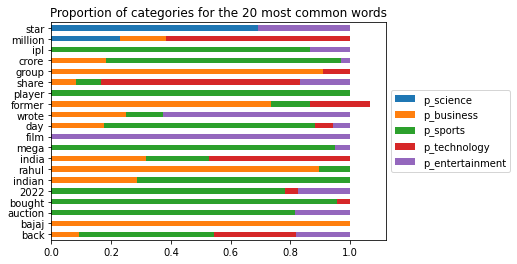

In [193]:
# figure out the percentage of language in words
(word_counts
 .assign(p_science = word_counts.science / word_counts['all'],
         p_business = word_counts.business / word_counts['all'],
         p_sports = word_counts.sports / word_counts['all'],
         p_technology = word_counts.technology / word_counts['all'],
         p_entertainment = word_counts.entertainment / word_counts['all'])
 .sort_values(by = 'all')
 [['p_science', 'p_business', 'p_sports', 'p_technology', 'p_entertainment']]
 .tail(20)
 .sort_values('p_science')
 .plot.barh(stacked=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Proportion of categories for the 20 most common words');

### Look at bigrams by language

Science Bigrams

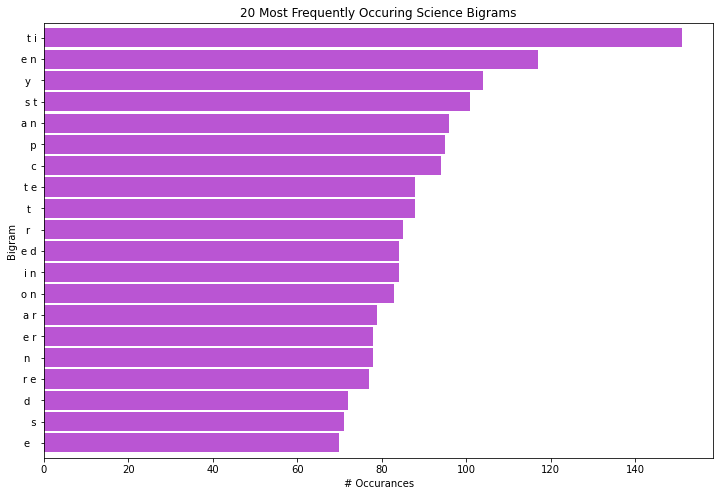

In [198]:
# Calculate bigrams
science_bigrams = (pd.Series(nltk.ngrams(science_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top Swift Bigrams
science_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most Frequently Occuring Science Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = science_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [221]:
news_df.lemmatized[0]

'nasa recently shared video showing infrared view north pole jupiter showed storm resembled pizza topping pepperoni calling phenomenon pepperoni storm nasa explained yellow area warmer deeper jupiter atmosphere dark area colder higher jupiter atmosphere'

## Modeling

In [225]:
news_df.rename(columns={'category':'target'}, inplace=True)

In [227]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(news_df.lemmatized)
y = news_df.target

## Train-Test Split
* 20% test
* Stratify on target

In [228]:
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=.2, random_state=333)

In [258]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

train['predicted'] = lm.predict(x_train)
test['predicted'] = lm.predict(x_test)

In [231]:
# baseline
news_df[news_df['target'] == 'science'].target.value_counts()/sum(news_df.target.value_counts())

science    0.201613
Name: target, dtype: float64

In [233]:
#Create evaluation dataframe
train = pd.DataFrame(dict(actual=y_train))
train['baseline']='science'
# Calculate baseline model performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.baseline)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.baseline, train.actual))
print('---')
print(classification_report(train.actual, train.baseline))

Accuracy: 20.20%
---
Confusion Matrix
actual    business  entertainment  science  sports  technology
baseline                                                      
science         20             20       20      20          19
---
               precision    recall  f1-score   support

     business       0.00      0.00      0.00        20
entertainment       0.00      0.00      0.00        20
      science       0.20      1.00      0.34        20
       sports       0.00      0.00      0.00        20
   technology       0.00      0.00      0.00        19

     accuracy                           0.20        99
    macro avg       0.04      0.20      0.07        99
 weighted avg       0.04      0.20      0.07        99



## Create models

### Logistic Regression Model

In [270]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'train_accuracy'])
eval_df

,model_type,target_var,train_accuracy


In [271]:
# Make and fit the object
lm = LogisticRegression().fit(x_train, y_train)
# Use it to make predictions
train['lm_predicted'] = lm.predict(x_train)
# Asssess accuracy
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.lm_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.lm_predicted))

Accuracy: 96.97%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
lm_predicted                                                       
business             19              0        0       0           0
entertainment         0             20        0       0           0
science               0              0       20       0           2
sports                0              0        0      20           0
technology            1              0        0       0          17
---
               precision    recall  f1-score   support

     business       1.00      0.95      0.97        20
entertainment       1.00      1.00      1.00        20
      science       0.91      1.00      0.95        20
       sports       1.00      1.00      1.00        20
   technology       0.94      0.89      0.92        19

     accuracy                           0.97        99
    macro avg       0.97      0.97      0.97        99
 weighted avg       0.97      0.97      

In [272]:
train

,actual,predicted,dt_predicted,dpredicted,lm_predicted
90,technology,technology,science,technology,technology
84,technology,technology,science,technology,technology
60,sports,sports,sports,sports,sports
94,technology,technology,science,technology,technology
91,technology,technology,science,technology,technology
...,...,...,...,...,...
45,business,business,science,technology,business
50,sports,sports,sports,sports,sports
21,science,science,science,technology,science
25,business,business,business,business,business


In [273]:
eval_df = eval_df.append({'model_type':'Logistic Regression', 'target_var':'target', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,target,0.969697


In [274]:
cross_val_score(lm, x_train, y_train, cv = 5)

array([0.55      , 0.75      , 0.8       , 0.85      , 0.68421053])

### Decision Tree

In [277]:
# Make and fit the object
dtc = DecisionTreeClassifier(max_depth = 4).fit(x_train, y_train)
# Use the object
train['dt_predicted'] = dtc.predict(x_train)
# Determine performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.dt_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.dt_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.dt_predicted))

Accuracy: 58.59%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
dt_predicted                                                       
business             12              0        0       0           0
entertainment         0              7        0       0           0
science               0              0        5       0           0
sports                0              0        0      15           0
technology            8             13       15       5          19
---
               precision    recall  f1-score   support

     business       1.00      0.60      0.75        20
entertainment       1.00      0.35      0.52        20
      science       1.00      0.25      0.40        20
       sports       1.00      0.75      0.86        20
   technology       0.32      1.00      0.48        19

     accuracy                           0.59        99
    macro avg       0.86      0.59      0.60        99
 weighted avg       0.87      0.59      

In [278]:
train

,actual,predicted,dt_predicted,dpredicted,lm_predicted
90,technology,technology,technology,technology,technology
84,technology,technology,technology,technology,technology
60,sports,sports,sports,sports,sports
94,technology,technology,technology,technology,technology
91,technology,technology,technology,technology,technology
...,...,...,...,...,...
45,business,business,technology,technology,business
50,sports,sports,sports,sports,sports
21,science,science,technology,technology,science
25,business,business,business,business,business


In [281]:
for i in range(3,11):
    dtc = DecisionTreeClassifier(max_depth = i).fit(x_train, y_train)

    train['dpredicted'] = dtc.predict(x_train)
    test['predicted'] = dtc.predict(x_test)
    
    print('Decision Tree Depth =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
    print('---')
    print('Train Data - Confusion Matrix')
    print(pd.crosstab(train.predicted, train.actual))
    print('---')
    print(classification_report(train.actual, train.predicted))
    
    print('Decision Tree Depth =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
    print('---')
    print('Test Data - Confusion Matrix')
    print(pd.crosstab(test.predicted, test.actual))
    print('---')
    print(classification_report(test.actual, test.predicted))
    print('------------------------------------------------------')
    
    eval_df = eval_df.append({'model_type':'Decision Tree Classifier - max depth = {}'.format(i), 'target_var':'category', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)

Decision Tree Depth = 3
Accuracy: 96.97%
---
Train Data - Confusion Matrix
actual         business  entertainment  science  sports  technology
predicted                                                          
business             19              0        0       0           0
entertainment         0             20        0       0           0
science               0              0       20       0           2
sports                0              0        0      20           0
technology            1              0        0       0          17
---
               precision    recall  f1-score   support

     business       1.00      0.95      0.97        20
entertainment       1.00      1.00      1.00        20
      science       0.91      1.00      0.95        20
       sports       1.00      1.00      1.00        20
   technology       0.94      0.89      0.92        19

     accuracy                           0.97        99
    macro avg       0.97      0.97      0.97        99
 we

               precision    recall  f1-score   support

     business       0.60      0.60      0.60         5
entertainment       1.00      0.60      0.75         5
      science       1.00      0.20      0.33         5
       sports       1.00      0.80      0.89         5
   technology       0.25      0.60      0.35         5

     accuracy                           0.56        25
    macro avg       0.77      0.56      0.59        25
 weighted avg       0.77      0.56      0.59        25

------------------------------------------------------
Decision Tree Depth = 8
Accuracy: 96.97%
---
Train Data - Confusion Matrix
actual         business  entertainment  science  sports  technology
predicted                                                          
business             19              0        0       0           0
entertainment         0             20        0       0           0
science               0              0       20       0           2
sports                0         

In [282]:
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,target,0.969697
1,Decision Tree Classifier - max depth = 3,category,0.969697
2,Decision Tree Classifier - max depth = 4,category,0.969697
3,Decision Tree Classifier - max depth = 5,category,0.969697
4,Decision Tree Classifier - max depth = 6,category,0.969697
5,Decision Tree Classifier - max depth = 7,category,0.969697
6,Decision Tree Classifier - max depth = 8,category,0.969697
7,Decision Tree Classifier - max depth = 9,category,0.969697
8,Decision Tree Classifier - max depth = 10,category,0.969697


### Random Forest

In [240]:
# Make and fit object
rf = RandomForestClassifier(bootstrap = True, 
                            class_weight = None, 
                            criterion = 'gini',
                            min_samples_leaf = 3,
                            n_estimators = 100,
                            max_depth = 8, 
                            random_state = 333).fit(x_train, y_train)
# Use it to make predictions
train['rf_predicted'] = rf.predict(x_train)
# Assess performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.rf_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.rf_predicted))

Accuracy: 86.87%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
rf_predicted                                                       
business             19              0        0       0           1
entertainment         1             17        1       1           1
science               0              2       17       1           2
sports                0              1        0      18           0
technology            0              0        2       0          15
---
               precision    recall  f1-score   support

     business       0.95      0.95      0.95        20
entertainment       0.81      0.85      0.83        20
      science       0.77      0.85      0.81        20
       sports       0.95      0.90      0.92        20
   technology       0.88      0.79      0.83        19

     accuracy                           0.87        99
    macro avg       0.87      0.87      0.87        99
 weighted avg       0.87      0.87      

In [242]:
cross_val_score(rf, x_train, y_train, cv = 4)

array([0.44, 0.56, 0.64, 0.5 ])

### KNN

In [284]:
# Make and fit the object
knn = KNeighborsClassifier(n_neighbors = 4).fit(x_train, y_train)
# Use the object 
train['knn_predicted'] = knn.predict(x_train)
# Evaluate performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.knn_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.knn_predicted))

Accuracy: 84.85%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
knn_predicted                                                      
business             17              2        1       0           0
entertainment         1             16        1       0           1
science               0              0       18       0           5
sports                0              1        0      20           0
technology            2              1        0       0          13
---
               precision    recall  f1-score   support

     business       0.85      0.85      0.85        20
entertainment       0.84      0.80      0.82        20
      science       0.78      0.90      0.84        20
       sports       0.95      1.00      0.98        20
   technology       0.81      0.68      0.74        19

     accuracy                           0.85        99
    macro avg       0.85      0.85      0.85        99
 weighted avg       0.85      0.85      

In [249]:
cross_val_score(knn, x_train, y_train, cv = 4)

array([0.6       , 0.68      , 0.8       , 0.79166667])

In [285]:
train

,actual,predicted,dt_predicted,dpredicted,lm_predicted,knn_predicted
90,technology,technology,technology,technology,technology,technology
84,technology,technology,technology,technology,technology,science
60,sports,sports,sports,sports,sports,sports
94,technology,technology,technology,technology,technology,technology
91,technology,technology,technology,technology,technology,science
...,...,...,...,...,...,...
45,business,business,technology,technology,business,business
50,sports,sports,sports,sports,sports,sports
21,science,science,technology,technology,science,science
25,business,business,business,business,business,business


In [286]:
for i in range(2,13):
    knn = KNeighborsClassifier(n_neighbors = i).fit(x_train, y_train)

    train['predicted'] = knn.predict(x_train)
    test['predicted'] = knn.predict(x_test)
    
    print('Value of K =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
    print('---')
    print('Train Data - Confusion Matrix')
    print(pd.crosstab(train.predicted, train.actual))
    print('---')
    print(classification_report(train.actual, train.predicted))
    
    print('Value of K =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
    print('---')
    print('Test Data - Confusion Matrix')
    print(pd.crosstab(test.predicted, test.actual))
    print('---')
    print(classification_report(test.actual, test.predicted))
    print('------------------------------------------------------')
    
    eval_df = eval_df.append({'model_type':'KNN - neighbors = {}'.format(i), 'target_var':'language', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)

Value of K = 2
Accuracy: 87.88%
---
Train Data - Confusion Matrix
actual         business  entertainment  science  sports  technology
predicted                                                          
business             20              1        1       0           4
entertainment         0             19        1       0           0
science               0              0       18       0           4
sports                0              0        0      20           1
technology            0              0        0       0          10
---
               precision    recall  f1-score   support

     business       0.77      1.00      0.87        20
entertainment       0.95      0.95      0.95        20
      science       0.82      0.90      0.86        20
       sports       0.95      1.00      0.98        20
   technology       1.00      0.53      0.69        19

     accuracy                           0.88        99
    macro avg       0.90      0.88      0.87        99
 weighted av

actual         business  entertainment  science  sports  technology
predicted                                                          
business             19              3        0       0           3
entertainment         0             12        1       0           0
science               0              0       18       0           3
sports                1              5        0      20           1
technology            0              0        1       0          12
---
               precision    recall  f1-score   support

     business       0.76      0.95      0.84        20
entertainment       0.92      0.60      0.73        20
      science       0.86      0.90      0.88        20
       sports       0.74      1.00      0.85        20
   technology       0.92      0.63      0.75        19

     accuracy                           0.82        99
    macro avg       0.84      0.82      0.81        99
 weighted avg       0.84      0.82      0.81        99

Value of K = 6
Accurac

Value of K = 11
Accuracy: 79.80%
---
Train Data - Confusion Matrix
actual         business  entertainment  science  sports  technology
predicted                                                          
business             18              2        0       0           3
entertainment         0             12        0       0           1
science               0              0       20       0           4
sports                1              6        0      20           2
technology            1              0        0       0           9
---
               precision    recall  f1-score   support

     business       0.78      0.90      0.84        20
entertainment       0.92      0.60      0.73        20
      science       0.83      1.00      0.91        20
       sports       0.69      1.00      0.82        20
   technology       0.90      0.47      0.62        19

     accuracy                           0.80        99
    macro avg       0.83      0.79      0.78        99
 weighted a

In [287]:
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,target,0.969697
1,Decision Tree Classifier - max depth = 3,category,0.969697
2,Decision Tree Classifier - max depth = 4,category,0.969697
3,Decision Tree Classifier - max depth = 5,category,0.969697
4,Decision Tree Classifier - max depth = 6,category,0.969697
5,Decision Tree Classifier - max depth = 7,category,0.969697
6,Decision Tree Classifier - max depth = 8,category,0.969697
7,Decision Tree Classifier - max depth = 9,category,0.969697
8,Decision Tree Classifier - max depth = 10,category,0.969697
9,KNN - neighbors = 2,language,0.878788


### Support Vector Classifier

In [288]:
# Make and fit the object
svc = LinearSVC(random_state=0).fit(x_train, y_train)
# Use the object
train['svc_predicted'] = svc.predict(x_train)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.svc_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.svc_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.svc_predicted))

Accuracy: 96.97%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
svc_predicted                                                      
business             19              0        0       0           0
entertainment         0             20        0       0           0
science               0              0       19       0           1
sports                0              0        0      20           0
technology            1              0        1       0          18
---
               precision    recall  f1-score   support

     business       1.00      0.95      0.97        20
entertainment       1.00      1.00      1.00        20
      science       0.95      0.95      0.95        20
       sports       1.00      1.00      1.00        20
   technology       0.90      0.95      0.92        19

     accuracy                           0.97        99
    macro avg       0.97      0.97      0.97        99
 weighted avg       0.97      0.97      

In [252]:
cross_val_score(svc, x_train, y_train, cv = 4)

array([0.68      , 0.8       , 0.96      , 0.70833333])

In [289]:
train

,actual,predicted,dt_predicted,dpredicted,lm_predicted,knn_predicted,svc_predicted
90,technology,business,technology,technology,technology,technology,technology
84,technology,science,technology,technology,technology,science,technology
60,sports,sports,sports,sports,sports,sports,sports
94,technology,technology,technology,technology,technology,technology,technology
91,technology,technology,technology,technology,technology,science,technology
...,...,...,...,...,...,...,...
45,business,business,technology,technology,business,business,business
50,sports,sports,sports,sports,sports,sports,sports
21,science,science,technology,technology,science,science,science
25,business,business,business,business,business,business,business


In [290]:
# Create testing dataframe
test = pd.DataFrame(dict(actual=y_test))
test['knn_predicted'] = knn.predict(x_test)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.knn_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.knn_predicted))

Accuracy: 72.00%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
knn_predicted                                                      
business              4              0        2       0           2
entertainment         1              5        1       0           0
science               0              0        2       0           0
sports                0              0        0       5           1
technology            0              0        0       0           2
---
               precision    recall  f1-score   support

     business       0.50      0.80      0.62         5
entertainment       0.71      1.00      0.83         5
      science       1.00      0.40      0.57         5
       sports       0.83      1.00      0.91         5
   technology       1.00      0.40      0.57         5

     accuracy                           0.72        25
    macro avg       0.81      0.72      0.70        25
 weighted avg       0.81      0.72      

In [291]:
test

,actual,knn_predicted
10,science,science
98,technology,sports
48,business,business
39,business,business
115,entertainment,entertainment
116,entertainment,entertainment
28,business,business
20,science,entertainment
123,entertainment,entertainment
92,technology,technology


In [294]:
b = pd.read_json('inshorts-2022-02-05.json')

In [296]:
b = prep_text(b, 'original', extra_words=add_to_stoplist)

In [299]:
b.lemmatized[0]

'ministry science technology friday announced team indian scientist developed selfdisinfecting antiviral mask fight covid19 mask biodegradable highly breathable washable nature per ministry coated copperbased nanoparticles efficient coronavirus well viral bacterial infection'

In [300]:
b

,category,original,stemmed,lemmatized
0,science,The Ministry of Science and Technology on Frid...,ministri scienc technolog friday announc team ...,ministry science technology friday announced t...
1,science,Omicron BA.2 variant has been found in 57 coun...,omicron ba2 variant found 57 countri tuesday b...,omicron ba2 variant found 57 country tuesday b...
2,science,"Scientists have discovered a new ""highly virul...",scientist discov highli virul variant hiv neth...,scientist discovered highly virulent variant h...
3,science,Two 9.9 crore-year-old flowers have been found...,99 croreyearold flower found perfectli preserv...,99 croreyearold flower found perfectly preserv...
4,science,The European Space Agency (ESA) has released a...,european space agenc esa releas pictur mar cra...,european space agency esa released picture mar...
...,...,...,...,...
120,entertainment,Abhishek Bachchan took to his Instagram handle...,abhishek bachchan took hi instagram handl shar...,abhishek bachchan took instagram handle share ...
121,entertainment,Singer Suresh Wadkar has said there is no shel...,singer suresh wadkar shelf life recal valu son...,singer suresh wadkar shelf life recall value s...
122,entertainment,Filmmaker Karan Johar has praised the trailer ...,filmmak karan johar prais trailer alia bhattst...,filmmaker karan johar praised trailer alia bha...
123,entertainment,"Rosamund Pike, known for films like 'Gone Girl...",rosamund pike known film like gone girl pride ...,rosamund pike known film like gone girl pride ...


In [301]:
x2= tfidf.fit_transform(b.lemmatized)
y2 = b.category

In [334]:
x_train, x_test, y_train, y_test = train_test_split(x2,y2, stratify=y2, test_size=.2, random_state=333)

In [337]:
pd.DataFrame(x_train.todense(), columns=tfidf.get_feature_names())

,10,100,1000,1000th,1030,11,110,113,117,12,...,yield,york,yorkbased,youngster,yoy,yuzvendra,zee,zipping,zoom,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.135305,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
# Make and fit the object
knn = KNeighborsClassifier(n_neighbors = 3).fit(x_train, y_train)
# Use the object 
train['knn_predicted'] = knn.predict(x_train)
# Evaluate performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.knn_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.knn_predicted))

Accuracy: 15.00%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
knn_predicted                                                      
business              3              4        5       7           8
entertainment         3              3        7       5           3
science               4              8        2       3           3
sports                9              2        3       3           2
technology            1              3        3       2           4
---
               precision    recall  f1-score   support

     business       0.11      0.15      0.13        20
entertainment       0.14      0.15      0.15        20
      science       0.10      0.10      0.10        20
       sports       0.16      0.15      0.15        20
   technology       0.31      0.20      0.24        20

     accuracy                           0.15       100
    macro avg       0.16      0.15      0.15       100
 weighted avg       0.16      0.15      

In [308]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [315]:
for i in range(2,13):
    knn = KNeighborsClassifier(n_neighbors = i).fit(x_train, y_train)

    train['predicted'] = knn.predict(x_train)
    test['predicted'] = knn.predict(x_test)
    
    print('Value of K =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
    print('---')
    print('Train Data - Confusion Matrix')
    print(pd.crosstab(train.predicted, train.actual))
    print('---')
    print(classification_report(train.actual, train.predicted))
    
    print('Value of K =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
    print('---')
    print('Test Data - Confusion Matrix')
    print(pd.crosstab(test.predicted, test.actual))
    print('---')
    print(classification_report(test.actual, test.predicted))
    print('------------------------------------------------------')
    
    eval_df = eval_df.append({'model_type':'KNN - neighbors = {}'.format(i), 'target_var':'language', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)

Value of K = 2
Accuracy: 82.00%
---
Train Data - Confusion Matrix
actual         business  entertainment  science  sports  technology
predicted                                                          
business             20              2        0       1           8
entertainment         0             18        0       0           0
science               0              0       20       2           4
sports                0              0        0      17           1
technology            0              0        0       0           7
---
               precision    recall  f1-score   support

     business       0.65      1.00      0.78        20
entertainment       1.00      0.90      0.95        20
      science       0.77      1.00      0.87        20
       sports       0.94      0.85      0.89        20
   technology       1.00      0.35      0.52        20

     accuracy                           0.82       100
    macro avg       0.87      0.82      0.80       100
 weighted av

actual         business  entertainment  science  sports  technology
predicted                                                          
business              3              1        1       1           2
entertainment         0              3        0       0           0
science               0              1        4       0           0
sports                0              0        0       4           1
technology            2              0        0       0           2
---
               precision    recall  f1-score   support

     business       0.38      0.60      0.46         5
entertainment       1.00      0.60      0.75         5
      science       0.80      0.80      0.80         5
       sports       0.80      0.80      0.80         5
   technology       0.50      0.40      0.44         5

     accuracy                           0.64        25
    macro avg       0.69      0.64      0.65        25
 weighted avg       0.69      0.64      0.65        25

----------------------

               precision    recall  f1-score   support

     business       0.60      0.60      0.60         5
entertainment       1.00      0.60      0.75         5
      science       0.80      0.80      0.80         5
       sports       0.80      0.80      0.80         5
   technology       0.57      0.80      0.67         5

     accuracy                           0.72        25
    macro avg       0.75      0.72      0.72        25
 weighted avg       0.75      0.72      0.72        25

------------------------------------------------------
Value of K = 11
Accuracy: 76.00%
---
Train Data - Confusion Matrix
actual         business  entertainment  science  sports  technology
predicted                                                          
business             14              1        1       0           6
entertainment         0             17        2       1           0
science               0              0       17       1           3
sports                0              0  

In [316]:
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,target,0.969697
1,Decision Tree Classifier - max depth = 3,category,0.969697
2,Decision Tree Classifier - max depth = 4,category,0.969697
3,Decision Tree Classifier - max depth = 5,category,0.969697
4,Decision Tree Classifier - max depth = 6,category,0.969697
5,Decision Tree Classifier - max depth = 7,category,0.969697
6,Decision Tree Classifier - max depth = 8,category,0.969697
7,Decision Tree Classifier - max depth = 9,category,0.969697
8,Decision Tree Classifier - max depth = 10,category,0.969697
9,KNN - neighbors = 2,language,0.878788


In [314]:
test['knn_predicted'] = knn.predict(x_test)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.knn_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.knn_predicted))


Accuracy: 56.00%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
knn_predicted                                                      
business              2              1        1       1           3
entertainment         0              3        0       0           0
science               0              1        4       1           0
sports                0              0        0       3           0
technology            3              0        0       0           2
---
               precision    recall  f1-score   support

     business       0.25      0.40      0.31         5
entertainment       1.00      0.60      0.75         5
      science       0.67      0.80      0.73         5
       sports       1.00      0.60      0.75         5
   technology       0.40      0.40      0.40         5

     accuracy                           0.56        25
    macro avg       0.66      0.56      0.59        25
 weighted avg       0.66      0.56      

In [318]:
b

,category,original,stemmed,lemmatized
0,science,The Ministry of Science and Technology on Frid...,ministri scienc technolog friday announc team ...,ministry science technology friday announced t...
1,science,Omicron BA.2 variant has been found in 57 coun...,omicron ba2 variant found 57 countri tuesday b...,omicron ba2 variant found 57 country tuesday b...
2,science,"Scientists have discovered a new ""highly virul...",scientist discov highli virul variant hiv neth...,scientist discovered highly virulent variant h...
3,science,Two 9.9 crore-year-old flowers have been found...,99 croreyearold flower found perfectli preserv...,99 croreyearold flower found perfectly preserv...
4,science,The European Space Agency (ESA) has released a...,european space agenc esa releas pictur mar cra...,european space agency esa released picture mar...
...,...,...,...,...
120,entertainment,Abhishek Bachchan took to his Instagram handle...,abhishek bachchan took hi instagram handl shar...,abhishek bachchan took instagram handle share ...
121,entertainment,Singer Suresh Wadkar has said there is no shel...,singer suresh wadkar shelf life recal valu son...,singer suresh wadkar shelf life recall value s...
122,entertainment,Filmmaker Karan Johar has praised the trailer ...,filmmak karan johar prais trailer alia bhattst...,filmmaker karan johar praised trailer alia bha...
123,entertainment,"Rosamund Pike, known for films like 'Gone Girl...",rosamund pike known film like gone girl pride ...,rosamund pike known film like gone girl pride ...


In [320]:
b.lemmatized[0]

'ministry science technology friday announced team indian scientist developed selfdisinfecting antiviral mask fight covid19 mask biodegradable highly breathable washable nature per ministry coated copperbased nanoparticles efficient coronavirus well viral bacterial infection'

In [321]:
x = tfidf.fit_transform(b.lemmatized)
y = b.category

In [323]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=.2, random_state=123)

In [325]:
test

,actual,knn_predicted,predicted
10,science,science,science
92,technology,business,sports
44,business,technology,business
38,business,business,business
117,entertainment,science,sports
103,entertainment,business,technology
37,business,technology,technology
20,science,science,science
112,entertainment,entertainment,entertainment
89,technology,technology,technology


In [326]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [328]:
# Make and fit the object
lm = LogisticRegression().fit(X_train, y_train)
# Use it to make predictions
train['lm_predicted'] = lm.predict(X_train)
# Asssess accuracy
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.lm_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.lm_predicted))

Accuracy: 94.00%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
lm_predicted                                                       
business             18              0        0       0           3
entertainment         0             20        0       0           0
science               0              0       20       0           1
sports                0              0        0      20           0
technology            2              0        0       0          16
---
               precision    recall  f1-score   support

     business       0.86      0.90      0.88        20
entertainment       1.00      1.00      1.00        20
      science       0.95      1.00      0.98        20
       sports       1.00      1.00      1.00        20
   technology       0.89      0.80      0.84        20

     accuracy                           0.94       100
    macro avg       0.94      0.94      0.94       100
 weighted avg       0.94      0.94      